In [1]:
import os
import vector
import mplhep
import numpy as np
import awkward as ak
import boost_histogram as bh
import matplotlib.pyplot as plt
import matplotlib as mpl

import mplhep
mplhep.style.use(mplhep.style.CMS) 

In [2]:
# CERNBox link: https://cernbox.cern.ch/s/jcg2o409jjoARcJ
#data_dir = '/eos/user/l/ltani/ML-tau-data/'
#zh_path = os.path.join(data_dir, 'zh.parquet')
#z_path = os.path.join(data_dir, 'z.parquet')
#qq_path = os.path.join(data_dir, 'qq.parquet')

In [3]:
# Training data
data_dir_temporary = '/scratch/persistent/joosep/ml-tau/20240520_qq_zh_2m_merged/'
zh_path = os.path.join(data_dir_temporary, 'zh_train.parquet')
z_path = os.path.join(data_dir_temporary, 'z_train.parquet')
qq_path = os.path.join(data_dir_temporary, 'qq_train.parquet')

In [4]:
# Read parquet files
zh_data = ak.from_parquet(zh_path)
z_data = ak.from_parquet(z_path)
qq_data = ak.from_parquet(qq_path)

In [5]:
# Print number of jets in the datasets
print(f"[ZH (H->tautau)] \t Num jets: {len(zh_data)}")
print(f"[Z  (Z->tautau)] \t Num jets: {len(z_data)}")
print(f"[qq] \t\t\t Num jets: {len(qq_data)}")

[ZH (H->tautau)] 	 Num jets: 1706814
[Z  (Z->tautau)] 	 Num jets: 366037
[qq] 			 Num jets: 2818742


In [6]:
# Access properties associated for each jet. Same for each dataset
zh_data.fields

['reco_cand_p4s',
 'reco_cand_charge',
 'reco_cand_pdg',
 'reco_jet_p4s',
 'reco_cand_dz',
 'reco_cand_d3',
 'reco_cand_dz_err',
 'reco_cand_d3_err',
 'reco_cand_d0',
 'reco_cand_z0',
 'reco_cand_d0_err',
 'reco_cand_z0_err',
 'gen_jet_p4s',
 'gen_jet_tau_decaymode',
 'gen_jet_tau_p4s',
 'gen_jet_full_tau_p4s']

## Description of variables

|  Name |  Description |
|---|---|
| reco_cand_p4s | 4-momenta per reco cand in the reco jet. |
| reco_cand_charge | Charge per cand in the jet.|
| reco_cand_pdg | PDGid per cand in the jet.|
| reco_jet_p4s | RecoJet 4-momenta. |
| reco_cand_dz | Longitudinal impact parameter per cand in the jet. For future steps. Fill value used for neutral cands as no track parameters can be calculated. |
| reco_cand_dz_err | Uncertainty of the longitudinal impact parameter per cand in the jet. For future steps. Fill value used for neutral cands as no track parameters can be calculated. |
| reco_cand_dxy | Transverse impact parameter per cand in the jet. For future steps. Fill value used for neutral cands as no track parameters can be calculated. |
| reco_cand_dxy_err | Uncertainty of the transverse impact parameter per cand in the jet. For future steps. Fill value used for neutral cands as no track parameters can be calculated. |
| gen_jet_p4s | GenJet 4-momenta. Matched with RecoJet within a cone of radius dR < 0.4.|
| gen_jet_tau_decaymode | Decay mode of the associated genTau. Jets that have associated leptonically decaying taus are removed, so there are no DM=16 jets. If no GenTau can be matched to GenJet within dR<0.4, fill value is used. |
| gen_jet_tau_p4s | Visible 4-momenta of the genTau. If no GenTau can be matched to GenJet within dR<0.4, fill value is used. |
| gen_jet_full_tau_p4s | Full 4-momenta (with neutrino) of the genTau matched to the genJet and recoJet. If no GenTau can be matched to GenJet within dR<0.4, fill value is used. (For debugging purposes)|

In [7]:
# Create 4-vectors from the information in the .parquet file data and access information such as energy or pT:

def to_p4(p4_obj):
    return vector.awk(
        ak.zip(
            {
                "mass": p4_obj.tau,
                "x": p4_obj.x,
                "y": p4_obj.y,
                "z": p4_obj.z,
            }
        )
    )

def to_bh(data, bins, cumulative=False):
    h1 = bh.Histogram(bh.axis.Variable(bins))
    h1.fill(data)
    if cumulative:
        h1[:] = np.sum(h1.values()) - np.cumsum(h1)
    return h1

gen_tau_p4s = to_p4(zh_data.gen_jet_tau_p4s)
reco_cand_p4s = to_p4(zh_data.reco_cand_p4s)
reco_jet_p4s = to_p4(zh_data.reco_jet_p4s)
gen_tau_pt = gen_tau_p4s.pt


In [8]:
# Particles around the jet axis
# Δη = η_jet − η_cands same for ΔΦ

def deltaphi(phi1, phi2):
    diff = phi1 - phi2
    return np.arctan2(np.sin(diff), np.cos(diff))

delta_phi = deltaphi(reco_jet_p4s.phi, reco_cand_p4s.phi)
delta_eta = reco_jet_p4s.eta - reco_cand_p4s.eta

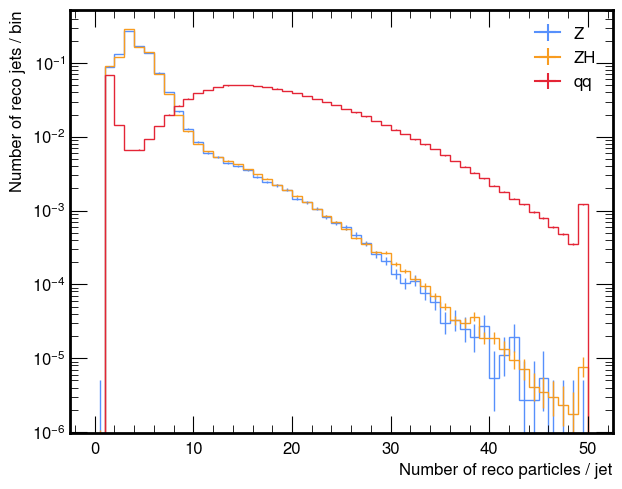

In [9]:
# Get number of particles per jet:
plt.figure(figsize=(7,5.5))
bins = np.linspace(0,50,51)

# Z plot
mplhep.histplot(to_bh(ak.num(z_data["reco_cand_p4s"]), bins=bins), 
                histtype="step", 
                lw=1, 
                flow="sum", 
                label="Z", 
                density=True)
# ZH plot
mplhep.histplot(to_bh(ak.num(zh_data["reco_cand_p4s"]), bins=bins),
                histtype="step",
                lw=1, flow="sum",
                label="ZH",
                density=True)
# qq plot
mplhep.histplot(to_bh(ak.num(qq_data["reco_cand_p4s"]), bins=bins),
                histtype="step",
                lw=1,
                flow="sum",
                label="qq",
                density=True)

plt.legend(loc="best", fontsize = 12)
plt.yscale("log")
plt.xlabel("Number of reco particles / jet", fontsize=12)
plt.ylabel("Number of reco jets / bin", fontsize=12)
plt.xticks(fontsize=12);
plt.yticks(fontsize=12);

Text(0, 1, 'Number of gen jets / bin')

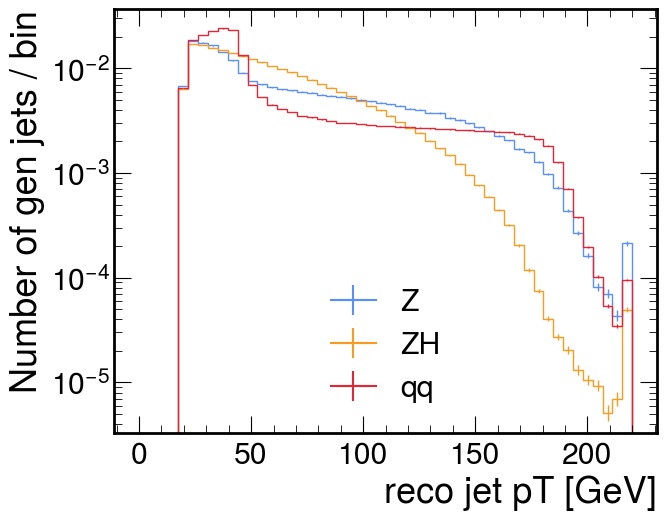

In [10]:
plt.figure(figsize=(7,5.5))
bins = np.linspace(0,220,51)
mplhep.histplot(to_bh(to_p4(z_data["reco_jet_p4s"]).pt, bins=bins), histtype="step", lw=1, flow="sum", label="Z", density=True)
mplhep.histplot(to_bh(to_p4(zh_data["reco_jet_p4s"]).pt, bins=bins), histtype="step", lw=1, flow="sum", label="ZH", density=True)
mplhep.histplot(to_bh(to_p4(qq_data["reco_jet_p4s"]).pt, bins=bins), histtype="step", lw=1, flow="sum", label="qq", density=True)
plt.legend(loc="best")
plt.yscale("log")
plt.xlabel("reco jet pT [GeV]")
plt.ylabel("Number of gen jets / bin")

Text(0, 1, 'matched jets / bin')

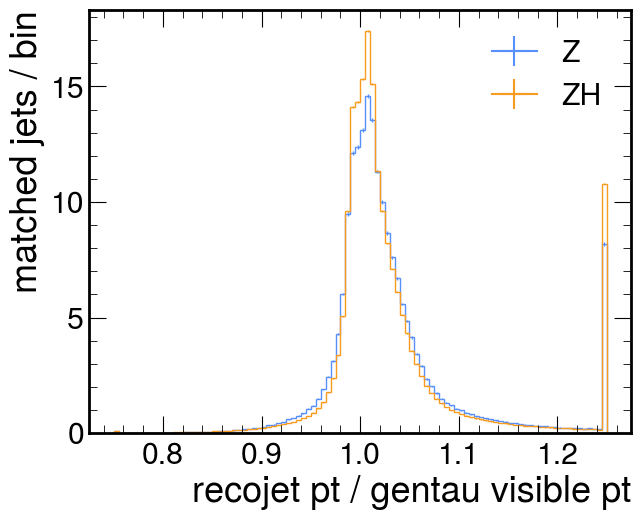

In [11]:
bins = np.linspace(0.75,1.25,101)
plt.figure(figsize=(7,5.5))
mplhep.histplot(
    to_bh(
        to_p4(z_data["reco_jet_p4s"]).pt / to_p4(z_data["gen_jet_tau_p4s"]).pt
    , bins=bins), histtype="step", lw=1, flow="sum", label="Z", density=True)

mplhep.histplot(
    to_bh(
        to_p4(zh_data["reco_jet_p4s"]).pt / to_p4(zh_data["gen_jet_tau_p4s"]).pt
    , bins=bins), histtype="step", lw=1, flow="sum", label="ZH", density=True)
plt.legend(loc="best")
# plt.yscale("log")
plt.xlabel("recojet pt / gentau visible pt")
plt.ylabel("matched jets / bin")

## Decaymode mapping:

| #  | Name              |                      |
|----|-------------------|--------------------------|
| 0  | OneProng0PiZero   | $\text{h}^\pm$               |
| 1  | OneProng1PiZero   | $\text{h}^\pm + \pi^0$       |
| 2  | OneProng2PiZero   | $\text{h}^\pm + 2\pi^0$      |
| 3  | OneProng3PiZero   | $\text{h}^\pm + 3\pi^0$      |
| 4  | OneProngNPiZero   | $\text{h}^\pm + n\pi^0$      |
| 5  | TwoProng0PiZero   | $\text{2h}$              |
| 6  | TwoProng1PiZero   | $\text{2h} + \pi^0$      |
| 7  | TwoProng2PiZero   | $\text{2h} + 2\pi^0$     |
| 8  | TwoProng3PiZero   | $\text{2h} + 3\pi^0$     |
| 9  | TwoProngNPiZero   | $\text{2h} + n\pi^0$     |
| 10 | ThreeProng0PiZero | $\text{3h}^\pm$              |
| 11 | ThreeProng1PiZero | $\text{3h}^\pm + \pi^0$      |
| 12 | ThreeProng2PiZero | $\text{3h}^\pm + 2\pi^0$     |
| 13 | ThreeProng3PiZero | $\text{3h}^\pm + 3\pi^0$     |
| 14 | ThreeProngNPiZero | $\text{3h}^\pm + n\pi^0$     |
| 15 | RareDecayMode     | Rare Decay Modes         |

In [12]:
def DM_percentages(data):
    """
    Calculate the percentages of decay modes in the given data.
    """
    uniques, counts = np.unique(data, return_counts=True)
    total_count = sum(counts)
    percentages = np.round((counts / total_count) * 100,2)
    return dict(zip(uniques, percentages))

z_data_percentages = DM_percentages(z_data["gen_jet_tau_decaymode"])
zh_data_percentages = DM_percentages(zh_data["gen_jet_tau_decaymode"])

print("Z Data Percentages:", z_data_percentages)
print("ZH Data Percentages:", zh_data_percentages)

Z Data Percentages: {0: 14.04, 1: 40.8, 2: 17.35, 3: 2.05, 4: 0.17, 10: 16.34, 11: 8.19, 12: 0.89, 15: 0.16}
ZH Data Percentages: {0: 14.34, 1: 40.84, 2: 17.15, 3: 2.05, 4: 0.16, 10: 16.32, 11: 8.1, 12: 0.88, 15: 0.15}


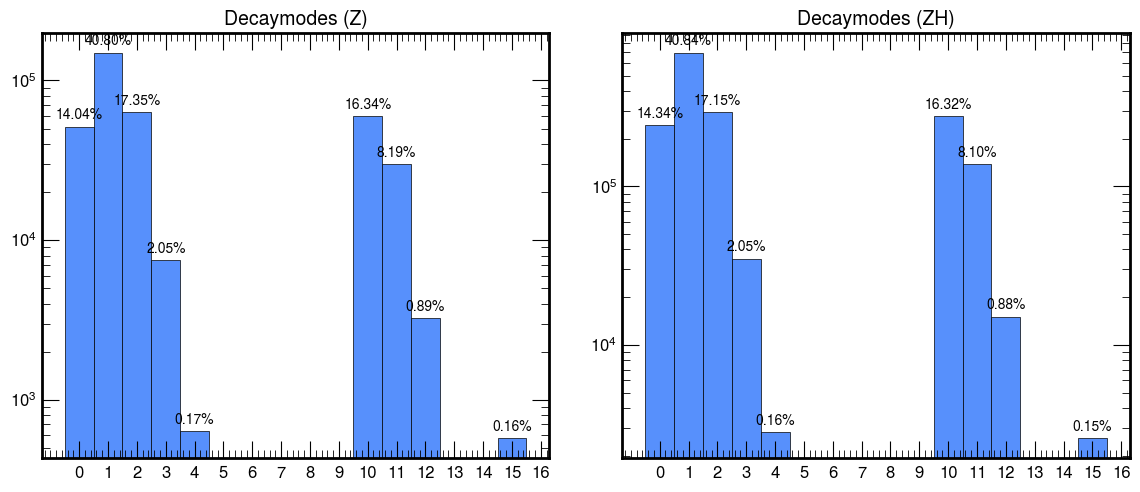

In [13]:
def annotate_bars(ax, percentages, total_count):
    for bar in ax.patches:
        height = bar.get_height()
        decay_mode = int(bar.get_x() + bar.get_width() / 2)
        percentage = percentages.get(decay_mode, 0)
        if height > 0:
            ax.annotate(f'{percentage:.2f}%', 
                        xy=(bar.get_x() + bar.get_width() / 2, height), 
                        xytext=(0, 3), 
                        textcoords="offset points", 
                        ha='center', va='bottom', fontsize=10)

dms = np.arange(17)

# Two subplots
fig, axs = plt.subplots(1, 2, figsize=(12,5.5))

# z_data hist
axs[0].set_title("Decaymodes (Z)", fontsize=14)
counts_z, _, bars_z = axs[0].hist(
    z_data["gen_jet_tau_decaymode"], bins=dms,
    width=1,
    edgecolor='black',
    linewidth=0.5
)
axs[0].set_yscale('log')
axs[0].set_xticks(dms + 0.5, dms)
axs[0].tick_params(axis='x', labelsize=12)
axs[0].tick_params(axis='y', labelsize=12)

# Annotate bars for z_data
annotate_bars(axs[0], z_data_percentages, total_count=len(z_data["gen_jet_tau_decaymode"]))

# zh_data hist
axs[1].set_title("Decaymodes (ZH)", fontsize=14)
counts_zh, _, bars_zh = axs[1].hist(
    zh_data["gen_jet_tau_decaymode"], bins=dms,
    width=1,
    edgecolor='black',
    linewidth=0.5
)
axs[1].set_yscale('log')
axs[1].set_xticks(dms + 0.5, dms)
axs[1].tick_params(axis='x', labelsize=12)
axs[1].tick_params(axis='y', labelsize=12)

# Annotate bars for zh_data
annotate_bars(axs[1], zh_data_percentages, total_count=len(zh_data["gen_jet_tau_decaymode"]))

plt.tight_layout()
plt.show()


## Decay mode remapping

In [14]:
dm_mapping = {
        0: 'OneProng0PiZero',
        1: 'OneProng1PiZero',
        2: 'OneProng2PiZero',
        3: 'OneProng3PiZero',
        4: 'OneProngNPiZero',
        5: 'TwoProng0PiZero',
        6: 'TwoProng1PiZero',
        7: 'TwoProng2PiZero',
        8: 'TwoProng3PiZero',
        9: 'TwoProngNPiZero',
        10: 'ThreeProng0PiZero',
        11: 'ThreeProng1PiZero',
        12: 'ThreeProng2PiZero',
        13: 'ThreeProng3PiZero',
        14: 'ThreeProngNPiZero',
        15: 'RareDecayMode'
    }

In [15]:
# Physically meaningful values are 0,1,2,3, 4, 10, 11, 12, 15
# Since some DM have a very small sample we classify them to "other"

# Remapped dictionary with meaningful DMs
remap_d = {0: '1h_0pi0',
           1: '1h_1pi0',
           2: '1h_2pi0',
           3: '1h_3pi0',
           4: '3h_0pi0',
           5: '3h_1pi0',
           6: 'Other'}

# Hard coded remapping function
def remap(dm_array):
    dm_array = ak.to_numpy(dm_array)
    new_array = dm_array.copy()

    # dm modes that are >1% 
    new_array[dm_array == 0] = 0 
    new_array[dm_array == 1] = 1
    new_array[dm_array == 2] = 2
    new_array[dm_array == 3] = 3
    new_array[dm_array == 10] = 4
    new_array[dm_array == 11] = 5
    
    # other decay modes that are <1%
    new_array[dm_array == 4] = 6
    new_array[dm_array == 12] = 6
    new_array[dm_array == 13] = 6
    new_array[dm_array == 14] = 6
    new_array[dm_array == 15] = 6

    # decay mode and it's coutns
    dm, N = np.unique(new_array, return_counts = True)
    
    return new_array, dm, N

z_remap = remap(z_data['gen_jet_tau_decaymode'])
zh_remap = remap(zh_data['gen_jet_tau_decaymode'])

## Probabilty cross check with PDG

In [16]:
# PDG values from  https://pdglive.lbl.gov/Particle.action?node=S035&init=0

def tau_only_percentage(list_of_percentages, initial_percent):
    """Cross product"""
    theo_per = []
    
    for i in list_of_percentages:
        theo_per.append(round(i / initial_percent, 4))

    return theo_per

def calculate_ratios_and_uncertainties(values, std_devs, initial_value, initial_std):
    """Calculate ratios and their uncertainties"""
    ratios = tau_only_percentage(values, initial_value)
    uncertainties = []
    
    for i in range(len(values)):
        A = values[i]
        sigma_A = std_devs[i]
        R = ratios[i]
        
        # Calculate relative uncertainty for the ratio
        relative_uncertainty = (sigma_A / A)**2 + (initial_std / initial_value)**2
        sigma_R = R * (relative_uncertainty)**0.5
        uncertainties.append(round(sigma_R, 4))
    
    return ratios, uncertainties

# Provided values and standard deviations
vals = [11.51, 25.93, 9.48, 1.18, 9.80, 4.76, 2.13]
std = [0.05, 0.09, 0.10, 0.07, 0.05, 0.05, 0.18] 
initial_perc = 64.79
initial_std = 0.06

# Calculate Z and ZH ratios for PDG comparison
z_ratios = tau_only_percentage(z_remap[2], sum(z_remap[2]))
zh_ratios = tau_only_percentage(zh_remap[2], sum(zh_remap[2]))

# Calculate ratios and uncertainties
PDG_ratios, PDG_uncertainties = calculate_ratios_and_uncertainties(vals, std, initial_perc, initial_std)
PDG_ratios, PDG_uncertainties

([0.1777, 0.4002, 0.1463, 0.0182, 0.1513, 0.0735, 0.0329],
 [0.0008, 0.0014, 0.0015, 0.0011, 0.0008, 0.0008, 0.0028])

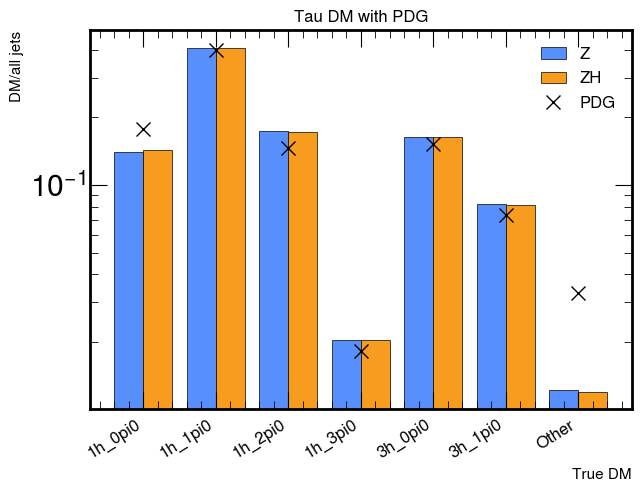

In [17]:
# Number of decay modes
ind = np.arange(len(PDG_ratios))

# Width of the bars
width = 0.4

plt.figure(figsize=(7, 5.5))

# Plot the bars for Z and ZH
plt.bar(ind, z_ratios, width, label='Z', edgecolor='black', linewidth=0.5)
plt.bar(ind + width, zh_ratios, width, label='ZH', edgecolor='black', linewidth=0.5)

# Plot the PDG ratios with error bars
plt.errorbar(ind + width / 2,
             PDG_ratios,
             #yerr=PDG_uncertainties,
             fmt='x',
             color='k',
             markersize=10,
             label='PDG')

# Set labels and title
plt.xlabel('True DM', fontsize=11)
plt.ylabel('DM/all jets', fontsize=11)
plt.title('Tau DM with PDG', fontsize=12)

# Set x-axis ticks and labels
plt.xticks(ind + width / 2, [remap_d[i] for i in remap_d], rotation=32, ha='right', fontsize=12)

# Set y-axis to logarithmic scale
plt.yscale('log')

plt.legend(loc='best', fontsize=12)
plt.tight_layout()
plt.show()

## Other cross check plots

## Jet 2D shapes

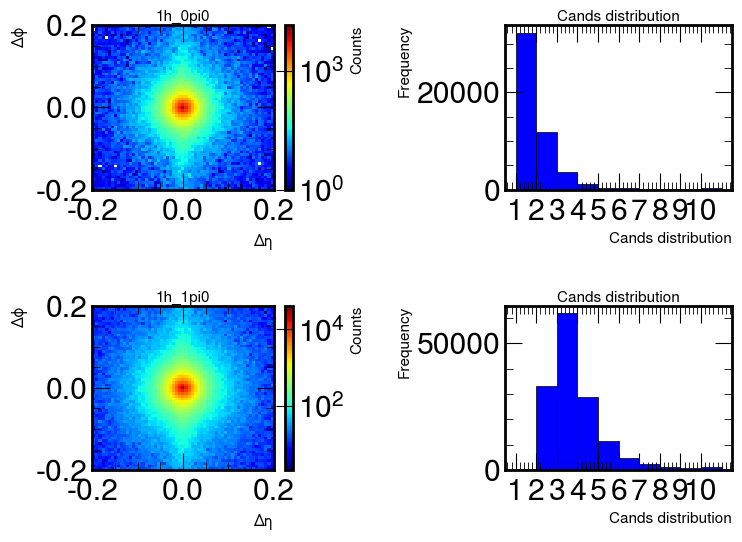

In [28]:
"""

lagunemiskanalite osakeste arvu jaotus

erinevate decay mode jettide arv võib olla erinev, keskmiselt näeb et decay modes kus on rohkem osakesi,
siis jetis peakski olema rohkem osakesi

"""

decay_modes_of_interest = [0, 1, 2, 3, 4, 5, 6]
decay_modes_of_interest = [0, 1]

rows = len(decay_modes_of_interest)
columbs = 2

fig, axss = plt.subplots(rows, columbs, figsize=(8, 3 * rows))

# väline
for idx_decaymode in range(rows):
    
    # teen vastava decay mode maski
    mask = (z_remap[0] == decay_modes_of_interest[idx_decaymode]) # jeti valikud true false 0-15
    cands = z_data["reco_cand_p4s"][mask] # jetide osakesed, mis decay mode on maskis
    jets = z_data["reco_jet_p4s"][mask] # jetid ise
    
    temp_list = []
    
    #sisemine loop üle jettide osakeste
    for idx_jet in range(len(cands)):
            
        # osakeste jaotuse histogramm
        temp_list.append(len(cands[idx_jet])) # list osakeste arvutst
            
    axss[idx_decaymode, 1].set_title("Cands distribution",
                            fontsize=11, pad=3, rotation='horizontal')
    
    axss[idx_decaymode, 1].set_xlabel("Cands distribution", fontsize=11) 
    axss[idx_decaymode, 1].set_ylabel("Frequency", fontsize=11)
    #lagunemiskanalid
    axss[idx_decaymode, 1].hist(temp_list, 
                                color = 'b',
                                bins=np.linspace(1,11,11),
                                edgecolor='black',
                                linewidth=0.5)
    axss[idx_decaymode, 1].set_xticks(np.arange(1, 11, 1))
    
    axss[idx_decaymode, 0].set_title(f'{remap_d[decay_modes_of_interest[idx_decaymode]]}',
                                     fontsize=11,
                                     pad=3,
                                     rotation='horizontal')
    
    hist = axss[idx_decaymode, 0].hist2d(ak.to_numpy(ak.flatten(delta_eta[mask])),
                                  ak.to_numpy(ak.flatten(delta_phi[mask])),
                                  bins=np.linspace(-0.2,0.2,60),
                                  norm=mpl.colors.LogNorm(), 
                                  cmap=mpl.cm.jet);
    
    axss[idx_decaymode, 0].set_xlabel(r"$\Delta \eta$", fontsize=11) 
    axss[idx_decaymode, 0].set_ylabel(r"$\Delta \phi$", fontsize=11)
    
    # Colorbar
    cbar = plt.colorbar(hist[3], ax=axss[idx_decaymode, 0])
    cbar.set_label('Counts', fontsize=11)

# Adjust layout
plt.tight_layout()


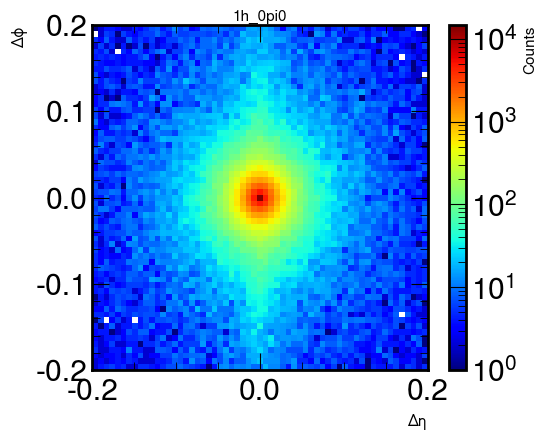

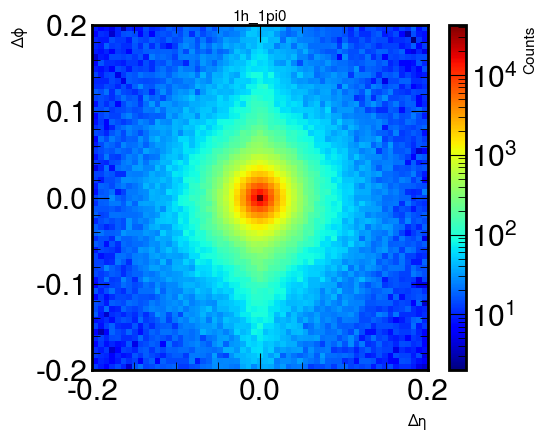

In [38]:
# Loop through each decay mode
for idx_decaymode in range(len(decay_modes_of_interest)):
    mask = (z_remap[0] == decay_modes_of_interest[idx_decaymode]) # Mask for the current decay mode
    
    # Create a new figure for each decay mode
    plt.figure(figsize=(6, 5))
    
    # Plot the 2D histogram of delta_eta and delta_phi
    hist2d = plt.hist2d(ak.to_numpy(ak.flatten(delta_eta[mask])),
                        ak.to_numpy(ak.flatten(delta_phi[mask])),
                        bins=np.linspace(-0.2, 0.2, 60),
                        norm=mpl.colors.LogNorm(), 
                        cmap=mpl.cm.jet)
    plt.xlabel(r"$\Delta \eta$", fontsize=11) 
    plt.ylabel(r"$\Delta \phi$", fontsize=11)
    plt.title(f'{remap_d[decay_modes_of_interest[idx_decaymode]]}', fontsize=11, pad=3, rotation='horizontal')
    cbar = plt.colorbar(hist2d[3])
    cbar.set_label('Counts', fontsize=11)

    plt.tight_layout()
    plt.show()

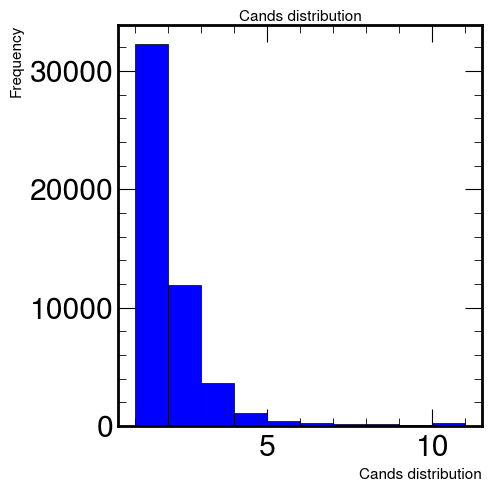

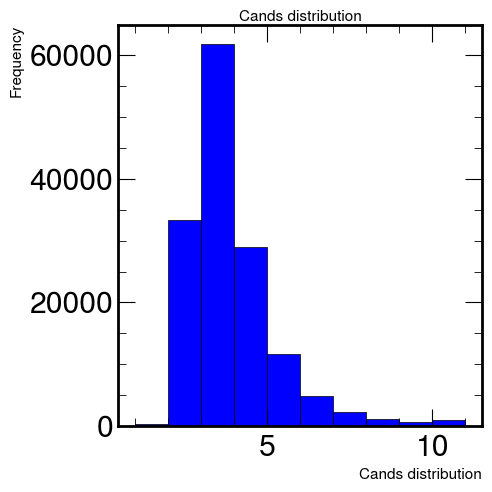

In [39]:
# Loop through each decay mode
for idx_decaymode in range(len(decay_modes_of_interest)):
    mask = (z_remap[0] == decay_modes_of_interest[idx_decaymode]) # Mask for the current decay mode
    cands = z_data["reco_cand_p4s"][mask]
    jets = z_data["reco_jet_p4s"][mask]
    
    # List to store particle counts per jet for the current decay mode
    cands_counts = []
    
    # Loop through jets to get particle counts
    for idx_jet in range(len(cands)):
        cands_counts.append(len(cands[idx_jet]))
    
    # Create a new figure for each decay mode
    plt.figure(figsize=(6, 5))
    
    # Plot the histogram of particle counts per jet
    plt.hist(cands_counts, color='b', bins=np.linspace(1, 11, 11),
             edgecolor='black', linewidth=0.5)
    plt.xlabel("Cands distribution", fontsize=11) 
    plt.ylabel("Frequency", fontsize=11)
    plt.title("Cands distribution", fontsize=11, pad=3, rotation='horizontal')

    plt.tight_layout()
    plt.show()

## any other input data visualizations

In [ ]:
# seaborn?